In [1]:
!wget https://download.pytorch.org/tutorial/data.zip -O data.zip
!unzip -u data.zip
!pip install lightning

--2023-11-29 10:30:37--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.72, 99.86.38.96, 99.86.38.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2023-11-29 10:30:37 (54.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [2]:
import glob
import unicodedata
import string
import os

def find_files(path: str):
    return glob.glob(path)

all_letters = string.ascii_letters + ' .,;'
n_letters = len(all_letters)

def unicode_to_ascii(text: str):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

category_lines = {}
all_categories = []

def read_lines(filename: str):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [3]:
import torch

def letter_to_index(letter: str):
    return all_letters.find(letter)

def letter_to_tensor(letter: str):
    tensor = torch.zeros(1, n_letters)
    tensor[0, letter_to_index(letter)] = 1
    return tensor

def line_to_tensor(line: str):
    tensor = torch.zeros(len(line), 1, n_letters)
    for indx, letter in enumerate(line):
        tensor[indx, 0, letter_to_index(letter)] = 1

    return tensor

# Model architecture based on linear layers (implicit rnn)

In [4]:
import lightning as L
import torch.nn as nn

class RNN(L.LightningModule):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()

        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input: torch.Tensor, hidden: torch.Tensor):
        combined = torch.cat((input, hidden), 1)

        hidden = self.linear1(combined)
        output = self.linear2(hidden)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

RNN(
  (linear1): Linear(in_features=184, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [5]:
input = letter_to_tensor('R')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.8871, -2.8168, -2.7594, -2.9844, -2.8892, -2.9223, -2.8954, -2.9296,
         -2.8390, -2.8043, -2.9217, -2.8863, -2.8822, -2.8571, -3.0006, -2.9303,
         -2.8783, -2.9765]], grad_fn=<LogSoftmaxBackward0>)

In [6]:
input = line_to_tensor('Rafal')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.8871, -2.8168, -2.7594, -2.9844, -2.8892, -2.9223, -2.8954, -2.9296,
         -2.8390, -2.8043, -2.9217, -2.8863, -2.8822, -2.8571, -3.0006, -2.9303,
         -2.8783, -2.9765]], grad_fn=<LogSoftmaxBackward0>)

In [7]:
def category_from_output(output):
    top_vals, top_indx = output.topk(1)
    category_indx = top_indx[0].item()
    return all_categories[category_indx], category_indx

print(category_from_output(output))

('Korean', 2)


In [8]:
import random

def random_training_example():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)

    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('category =', category, '/ line =', line)

category = Chinese / line = Mar
category = Polish / line = Szczepanski
category = Scottish / line = Fleming
category = Scottish / line = Wallace
category = Spanish / line = Salazar
category = Korean / line = Byon
category = Japanese / line = Nishimuraya
category = Arabic / line = Atiyeh
category = Dutch / line = Ramakers
category = Irish / line = Seaghdha


In [9]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(cateogry_tensor, line_tensor):
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.shape[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [10]:
import time
import math
from tqdm import tqdm

n_iters = 100_000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

for i in tqdm(range(1, n_iters+1)):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if i % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print(f'{loss} {line} / {guess} {correct}')
        # print('%d %d%% %.4f %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  5%|▌         | 5074/100000 [00:13<02:35, 608.96it/s]

2.6017394065856934 Theunissen / Polish ✗ (Dutch)


 10%|█         | 10006/100000 [00:21<04:09, 361.35it/s]

1.1743991374969482 Cho / Korean ✓


 15%|█▌        | 15093/100000 [00:32<02:56, 479.89it/s]

1.4520899057388306 Rosario / Spanish ✗ (Portuguese)


 20%|██        | 20097/100000 [00:39<01:32, 861.01it/s]

0.7667130827903748 Takano / Japanese ✓


 25%|██▌       | 25123/100000 [00:45<01:37, 767.05it/s]

1.848281979560852 Truong / Scottish ✗ (Vietnamese)


 30%|███       | 30115/100000 [00:54<01:19, 876.12it/s]

1.9559141397476196 Felix / Irish ✗ (French)


 35%|███▌      | 35151/100000 [01:00<01:15, 856.83it/s]

2.546656608581543 Aalst / French ✗ (Dutch)


 40%|████      | 40096/100000 [01:07<02:07, 470.27it/s]

2.7177278995513916 Wiesner / German ✗ (Czech)


 45%|████▌     | 45011/100000 [01:16<01:59, 459.20it/s]

0.9194791316986084 Acone / Italian ✓


 50%|█████     | 50089/100000 [01:25<01:01, 817.75it/s]

1.3440731763839722 Ochoa / Spanish ✓


 55%|█████▌    | 55092/100000 [01:32<01:14, 606.13it/s]

2.699608325958252 Coma / Spanish ✗ (Czech)


 60%|██████    | 60146/100000 [01:38<00:45, 885.30it/s]

1.6156152486801147 Mata / Japanese ✗ (Portuguese)


 65%|██████▌   | 65090/100000 [01:44<00:39, 883.51it/s]

0.19637539982795715 Ta / Vietnamese ✓


 70%|███████   | 70127/100000 [01:51<00:36, 828.69it/s]

0.0155666284263134 Mizumaki / Japanese ✓


 75%|███████▌  | 75126/100000 [01:57<00:30, 819.31it/s]

2.8340725898742676 Dcruze / Scottish ✗ (Spanish)


 80%|████████  | 80099/100000 [02:04<00:22, 890.75it/s]

1.3881349563598633 Lam / Vietnamese ✗ (Chinese)


 85%|████████▌ | 85159/100000 [02:10<00:17, 855.28it/s]

2.5219264030456543 Winograd / Irish ✗ (Polish)


 90%|█████████ | 90152/100000 [02:17<00:11, 850.95it/s]

1.3992677927017212 Gerges / Arabic ✓


 95%|█████████▌| 95125/100000 [02:23<00:05, 870.94it/s]

1.2431172132492065 Song / Chinese ✗ (Korean)


100%|██████████| 100000/100000 [02:30<00:00, 663.79it/s]

5.533718585968018 De la fuente / Scottish ✗ (Spanish)


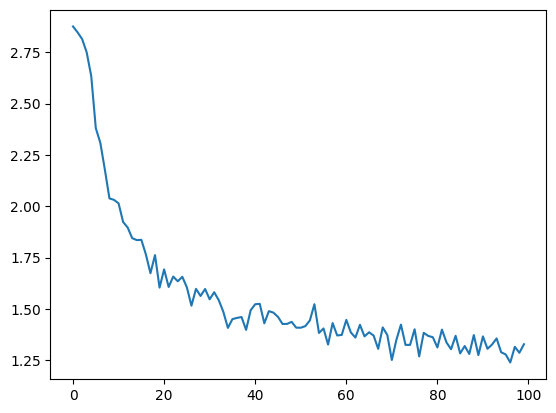

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.plot(all_losses)

<ipython-input-12-d9f73ea9371d>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-12-d9f73ea9371d>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


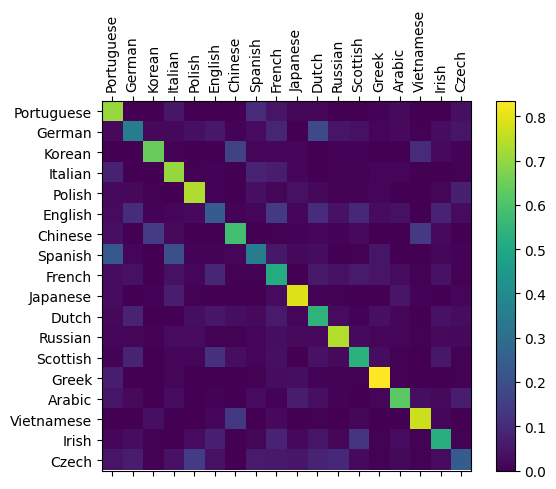

In [12]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [13]:
def predict(input_line, n_predictions=3):
    print(f'> {input_line}')

    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        top_values, top_index = output.topk(n_predictions, -1, True)
        predictions = []

        for i in range(n_predictions):
            value = top_values[0,i].item()
            category_index = top_index[0,i].item()
            print(f'({value:.2f}) {all_categories[category_index]}')
            predictions.append([value, all_categories[category_index]])
        print()

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Jarmakiewicz')

> Dovesky
(-0.82) Russian
(-1.15) Czech
(-2.27) English

> Jackson
(-1.17) English
(-1.27) Scottish
(-2.09) Czech

> Satoshi
(-1.11) Japanese
(-1.31) Italian
(-2.35) Czech

> Jarmakiewicz
(-1.00) German
(-1.99) Russian
(-2.13) Czech



In [14]:
from torch.utils.data import Dataset, DataLoader

class CountryNamesDataset(Dataset):
    def __init__(self, all_categories, category_lines):
        countries_to_numbers = dict([i[::-1] for i in enumerate(all_categories)])
        country_and_name = [[country, name] for country in all_categories for name in category_lines[country]]
        self.countries = [countries_to_numbers[i[0]] for i in country_and_name]
        self.names = [i[1] for i in country_and_name]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, indx):
        country = torch.tensor([self.countries[indx]])
        name = line_to_tensor(self.names[indx])

        return name, country

In [15]:
dataset = CountryNamesDataset(all_categories, category_lines)
dataloader = DataLoader(dataset, shuffle=True, num_workers=2)

# Architecture based on LSTM rnn

In [16]:
import torch.nn.functional as F
import torch.optim as optim

class MyRNN(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        # Input.shape: [seq_size, batch_size, vocab_size]
        self.rnn = nn.LSTM(input_size, hidden_size)
        # Rnn.shape: [seq_size, batch_size, hidden_size]
        self.linear = nn.Linear(hidden_size, output_size)
        # Linear.shape: [seq_size, batch_size, n_categories]

    def forward(self, x):
        x, (h_n, c_n) = self.rnn(x)
        x = self.linear(h_n)

        return x

    def training_step(self, batch, batch_indx):
        x, y = batch
        x, y = x[0], y[0]
        output = self(x)

        loss = F.cross_entropy(output[0], y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

myrnn2 = MyRNN(n_letters, n_hidden, n_categories)
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=myrnn2, train_dataloaders=dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params
----------------------------------
0 | rnn    | LSTM   | 95.2 K
1 | linear | Linear | 2.3 K 
----------------------------------
97.6 K    Trainable params
0         Non-trainable params
97.6 K    Total params
0.390     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name   | Type   | Param

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
def predict(input_line, n_predictions=3):
    print(f'> {input_line}')

    with torch.no_grad():
        output = myrnn2(line_to_tensor(input_line))
        output = F.softmax(output, dim=-1)

        top_values, top_index = output.topk(n_predictions, -1)
        predictions = []

        for i in range(n_predictions):
            value = top_values[0,0,i].item()
            category_index = top_index[0,0,i].item()
            print(f'({value:.2f}) {all_categories[category_index]}')
            predictions.append([value, all_categories[category_index]])
        print()

predict('Dovesky')
predict('Jackson')
predict('Smiths')
predict('Satoshi')
predict('Jarmakiewicz')
predict('Kowalski')

> Dovesky
(1.00) Russian
(0.00) Czech
(0.00) English

> Jackson
(0.91) English
(0.09) Scottish
(0.00) Czech

> Smiths
(0.52) English
(0.31) Dutch
(0.09) Scottish

> Satoshi
(0.99) Japanese
(0.01) Russian
(0.00) Chinese

> Jarmakiewicz
(0.99) Polish
(0.00) German
(0.00) Czech

> Kowalski
(0.96) Polish
(0.03) Czech
(0.01) Japanese

